Group 30:

1.   Panagiotis Banos(1622773)
2.   Ali Sanaei Namaghi (1579274)



# Preparation

In [82]:
# Install PyTorch Geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [83]:
import torch
import torch.nn.functional as F
import requests
import io
import pickle
import json
import numpy as np

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [84]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [85]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

num_test_labels = sum(data_1.test_mask)



print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')
print(f'Num test labels: {num_test_labels}')

print(f'Average node degree: {num_edge / num_node:.2f}')
print(f'Contains isolated nodes: {data_1.contains_isolated_nodes()}')
print(f'Contains self-loops: {data_1.contains_self_loops()}')
print(f'Is directed: {data_1.is_directed()}')


Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522
Num test labels: 5348
Average node degree: 23.54
Contains isolated nodes: True
Contains self-loops: True
Is directed: True


In [86]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [87]:
def print_node(idx, query_node = False, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    # print(node_info)
    print(f'--Node {idx}--')
    if url:
        if query_node : print("*****Query Article*****")
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [88]:
node_labels = []
for idx in range(num_node):
  node = data_metadata['nodes'][idx]
  label = node['label']
  node_labels.append(label)


In [89]:
for i in range(5):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security



In [90]:
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GraphConv, VGAE
from torch.nn import Linear, Conv1d, LeakyReLU, BatchNorm1d
import torch.nn.functional as F

class GraphEmbeddingNetwork(torch.nn.Module):
  def __init__(self, n_features, hidden_channels, linear_channels, output_channels, in_heads, out_heads, mode="retrieval"):
      super(GraphEmbeddingNetwork, self).__init__()
      
      self.in_heads = in_heads
      self.out_heads = out_heads
      self.mode = mode
      
      self.conv1 = GATConv(n_features, hidden_channels, heads=self.in_heads)
      self.conv2 = GATConv(self.in_heads*hidden_channels, linear_channels, heads=self.out_heads)

      #embedding layer "a la" Retrieval with Neural Codes
      self.embeddingLayer = Linear(linear_channels, linear_channels)

      #mu and sigma for task 2
      self.mu = GATConv(linear_channels, output_channels, heads=self.out_heads)
      self.log_sigma = GATConv (linear_channels, output_channels, heads=self.out_heads)


      self.leaky_relu = LeakyReLU(negative_slope=0.01)
      self.batch_norm1 = BatchNorm1d(self.in_heads*hidden_channels)
      self.batch_norm2 = BatchNorm1d(self.out_heads*linear_channels)

  def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(device)
        z = mu + sigma * epsilon
        return z

  def forward(self, x, edge_index):
   
    if (self.mode == "retrieval"):
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)  # activation function
        x = F.dropout(x, p=0.7, training=self.training)  # attempt to combat overfitting, as we only have few labels

        x = self.conv2(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                        # this final update transforms each node embedding to a class prediction
                                        # we do not apply an activation, as the PyTorch CCE calculation
                                        # takes care of treating this output as 'softmax'.
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.7, training=self.training)
        x = self.embeddingLayer(x)

        return x

    if (self.mode == "task2"):
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        mu = self.mu(x,edge_index)
        log_sigma = self.log_sigma(x, edge_index)
        z = self.reparameterization(mu, log_sigma)
        # print(f'Mu: {mu}')
        # print(f'Sigma: {log_sigma}')

        return z, mu, log_sigma

GraphEmbeddingNetwork(
  (conv1): GATConv(300, 300, heads=3)
  (conv2): GATConv(900, 128, heads=1)
  (embeddingLayer): Linear(in_features=128, out_features=128, bias=True)
  (mu): GATConv(128, 64, heads=1)
  (log_sigma): GATConv(128, 64, heads=1)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (batch_norm1): BatchNorm1d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch: 010, Loss: 1.1815, Train Acc: 0.6609, Test Acc: 0.6071
Epoch: 020, Loss: 0.6750, Train Acc: 0.7337, Test Acc: 0.6485
Epoch: 030, Loss: 0.4865, Train Acc: 0.8218, Test Acc: 0.7225
Epoch: 040, Loss: 0.3876, Train Acc: 0.8985, Test Acc: 0.7629
Epoch: 050, Loss: 0.3093, Train Acc: 0.9349, Test Acc: 0.7646


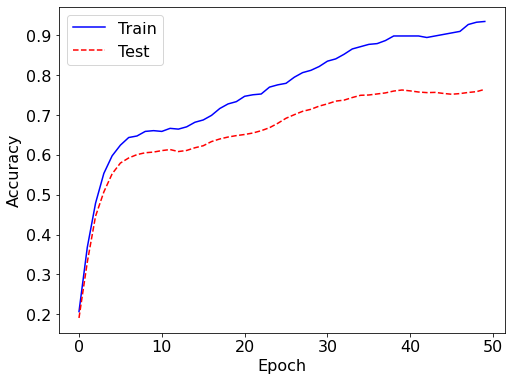

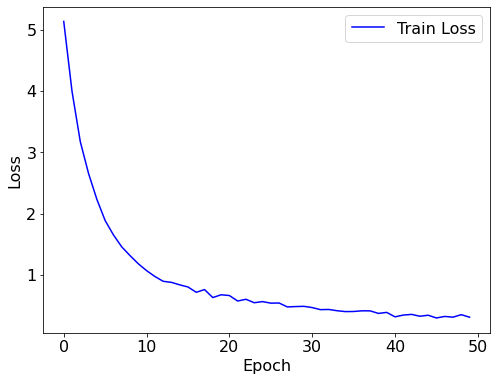

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_gnn = GraphEmbeddingNetwork(n_features=num_node_feature, hidden_channels=300, \
              linear_channels=128, output_channels = 64, in_heads=3, out_heads=1, mode="retrieval") \
              .to(device)
data_1 = data_1.to(device)
print(model_gnn)

# same loss and optimizer as before
loss_func = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.005, weight_decay=5e-4)

def train_gnn():
    model_gnn.train()  # set the model to training 'mode' 
    optimizer.zero_grad()  # set gradients to 0
    out = model_gnn(data_1.x, data_1.edge_index)  # propagate the data through the model
    loss = loss_func(out[data_1.train_mask], data_1.y[data_1.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    train_loss.append(loss)

    return loss

def test_gnn(mask):
    model_gnn.eval()  # set the model to evaluation 'mode' 
    out = model_gnn(data_1.x, data_1.edge_index)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data_1.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy

    return test_acc

train_accs, train_loss = [], []
test_accs, test_loss = [], []

epochs = 50

for epoch in range(1, epochs+1): 
    loss = train_gnn()  # do one training step over the entire dataset
    train_acc = test_gnn(data_1.train_mask)  # compute the training accuracy
    test_acc = test_gnn(data_1.test_mask)  # compute the test accuracy
    if (epoch % 10) == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(train_accs, test_accs=None, context="train"):
    
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    if (context == "train"):
      ax.plot(train_accs, color='blue', label='Train')
      ax.plot(test_accs, color='red', linestyle='--', label='Test')
      ax.set_ylabel('Accuracy', fontsize=fnt)
    else:
      ax.plot(train_accs, color='blue', label='Train Loss')
      ax.set_ylabel('Loss', fontsize=fnt)
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    
plot_train(train_accs,test_accs,context="train")
plot_train(train_loss,context="loss")

In [92]:
def gatherEmbeddings(raw_embeddings):
  emb = []
  for node in range(num_node):
    emb.append(raw_embeddings[node])
  return emb

In [93]:
from torch.nn import CosineSimilarity

model_gnn.eval()

#kNearest articles
def kNearestArticles(model,qArticle, topk=5):
  distance_measure = CosineSimilarity(dim=1, eps=1e-6)
  
  topk += 1
  calculated_distances = []
  with torch.no_grad():
    extracted_embeddings = model(data_1.x, data_1.edge_index) #extract the embeddings of all the articles
  qArticle_embedding = extracted_embeddings[qArticle] #keep the query article in a seperate embedding

  articleList = gatherEmbeddings(extracted_embeddings)
  for candidateArticle in articleList: # foreach pair of <query,candidate> calculate their similarity
    similarity = distance_measure(qArticle_embedding.unsqueeze(0), candidateArticle.unsqueeze(0))
    calculated_distances.append(similarity.data.cpu().numpy())

  calculated_distances = np.argsort(np.array(calculated_distances).flatten()) # sort the calculated similarities

  calculated_distances = calculated_distances[-topk:] # reversal of the list to have a descendig order of similarity
  
  print_node(qArticle, query_node=True) # Just print the top-5
  for i,idx in enumerate(calculated_distances):
    if (idx != qArticle):
      print_node(idx)

# Nodes 1210, 2966, 5912, 3478, 7692, 84 are good for showing that the model can learn the context of each article
kNearestArticles(model_gnn,qArticle=1210,topk=5)
  

--Node 1210--
*****Query Article*****
https://en.wikipedia.org/wiki/JFugue
Label: Programming language topics

--Node 10142--
https://en.wikipedia.org/wiki/POV-Ray
Label: Programming language topics

--Node 9419--
https://en.wikipedia.org/wiki/Presentation_semantics
Label: Programming language topics

--Node 1390--
https://en.wikipedia.org/wiki/Extempore_(software)
Label: Programming language topics

--Node 10321--
https://en.wikipedia.org/wiki/JMusic
Label: Programming language topics

--Node 791--
https://en.wikipedia.org/wiki/Nyquist_(programming_language)
Label: Programming language topics



# Task 2

In [94]:
## Build the anomaly detection model ##

In [95]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [96]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [97]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


In [98]:
class GVAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(GVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x, edge_index):
        z, mu, log_sigma = self.encoder(x, edge_index)
        x_reconstr = self.decoder(z, edge_index)
        
        return x_reconstr, mu, log_sigma

In [99]:
def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = F.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss


In [100]:
class GraphEmbeddingEncoder(torch.nn.Module):
  def __init__(self, n_features, hidden_channels, output_channels):
      super(GraphEmbeddingEncoder, self).__init__()
      
      
      self.conv1 = SAGEConv(n_features, hidden_channels)
      self.conv2 = SAGEConv(hidden_channels, hidden_channels)

      self.mu = SAGEConv(hidden_channels, output_channels)
      self.log_sigma = SAGEConv(hidden_channels, output_channels)

      self.leaky_relu = LeakyReLU()

  def reparameterization(self, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    epsilon = torch.rand_like(sigma).to(device)
    z = mu + sigma * epsilon
    # print(z.size())
    return z

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = self.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = self.leaky_relu(x)
    mu = self.mu(x,edge_index)
    log_sigma = self.log_sigma(x, edge_index)
    z = self.reparameterization(mu, log_sigma)
    return z, mu, log_sigma




In [101]:
class GraphEmbeddingDecoder(torch.nn.Module):
  def __init__(self, z_size, hidden_channels, output_channels):
      super(GraphEmbeddingDecoder, self).__init__()
      
      self.conv1 = SAGEConv(z_size, hidden_channels)
      self.conv2 = SAGEConv(hidden_channels, output_channels)
      self.conv3 = SAGEConv(output_channels,output_channels)

      self.leaky_relu = LeakyReLU()

  def forward(self, x, edge_index):
      x = self.conv1(x, edge_index)
      x = self.leaky_relu(x)
      x = self.conv2(x, edge_index)
      x = self.leaky_relu(x)
      x = self.conv3(x,edge_index)

      return x

In [102]:
from torch_geometric.nn import VGAE

HIDDEN_CHANNELS = 300
OUTPUT_CHANNELS = 64

encoder = GraphEmbeddingEncoder(n_features=num_node_feature, hidden_channels=HIDDEN_CHANNELS, \
               output_channels=OUTPUT_CHANNELS) \
              .to(device)
decoder = GraphEmbeddingDecoder(z_size=OUTPUT_CHANNELS, hidden_channels=HIDDEN_CHANNELS, \
               output_channels = num_node_feature) \
              .to(device)

gvae = GVAE(encoder=encoder, decoder=decoder)

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gvae = gvae.to(device)
print(gvae)

optimizer = torch.optim.Adam(gvae.parameters(), lr=0.005, weight_decay=5e-4)

def train_vae():
    gvae.train() 
    optimizer.zero_grad() 

    z, mu, log_sigma = gvae(data_1.x, data_1.edge_index)
    agg_loss, rec_loss, kl_loss = loss_function(data_1.x, z, mu, log_sigma)
    
    
    agg_loss.backward() 
    optimizer.step() 
    # total_loss.append(agg_loss)

    return agg_loss, rec_loss, kl_loss

total_tot_loss = []
total_rec_loss, total_kl_loss = [], []

epochs = 50

for epoch in range(1, epochs+1): 
    tot_loss, rec_loss, kl_loss,  = train_vae()
    total_tot_loss.append(tot_loss)
    total_rec_loss.append(rec_loss)
    total_kl_loss.append(kl_loss)
    if (epoch % 10) == 0:
        print(f'Epoch: {epoch:03d}, Total Loss: {tot_loss/num_node:.4f}, Reconstruction Loss: {rec_loss/num_node:.4f}, KL_Loss: {kl_loss/num_node:.4f}')


GVAE(
  (encoder): GraphEmbeddingEncoder(
    (conv1): SAGEConv(300, 300)
    (conv2): SAGEConv(300, 300)
    (mu): SAGEConv(300, 64)
    (log_sigma): SAGEConv(300, 64)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (decoder): GraphEmbeddingDecoder(
    (conv1): SAGEConv(64, 300)
    (conv2): SAGEConv(300, 300)
    (conv3): SAGEConv(300, 300)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
)
Epoch: 010, Total Loss: 3.6722, Reconstruction Loss: 3.5441, KL_Loss: 0.1280
Epoch: 020, Total Loss: 2.0569, Reconstruction Loss: 2.0210, KL_Loss: 0.0359
Epoch: 030, Total Loss: 1.9138, Reconstruction Loss: 1.9007, KL_Loss: 0.0131
Epoch: 040, Total Loss: 1.8632, Reconstruction Loss: 1.8513, KL_Loss: 0.0120
Epoch: 050, Total Loss: 1.8373, Reconstruction Loss: 1.8241, KL_Loss: 0.0132


In [104]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(F.mse_loss(x_reconstr, x, reduction='none'))
    constant_term = OUTPUT_CHANNELS * 0.5 * np.log(np.pi)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [105]:
x_original_list_normal = []
x_reconstr_list_normal = []
elbos_normal = []
x_original_list_anomaly = []
x_reconstr_list_anomaly = []
elbos_anomaly = []

gvae.eval()
with torch.no_grad():
    data_2.to(device)
    
    z, mu, log_sigma = gvae(data_2.x, data_2.edge_index) # Propagate the test data through the network
    
    for i in range(num_node, total_node): #take into account only the newly added articles

      elbo, reconstr_loss, kl_loss = elbo_elementwise(data_2.x[i], z[i], mu[i], log_sigma[i]) #calculate the elbo, rec_loss and kl_loss 
                                                                                              #as shown in the practical
      if (is_anomaly[i] == 0):
        x_original_list_normal.append(data_2.x[i])
        x_reconstr_list_normal.append(z[i])
        elbos_normal.append(elbo.item())
      if (is_anomaly[i] == 1):
        x_original_list_anomaly.append(data_2.x[i])
        x_reconstr_list_anomaly.append(z[i])
        elbos_anomaly.append(elbo.item())


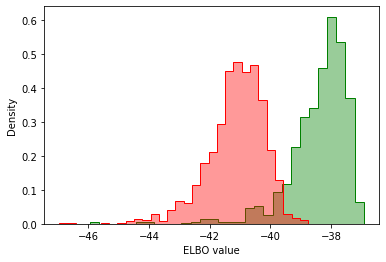

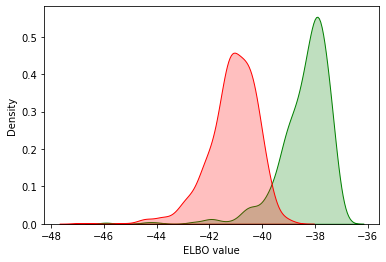

In [106]:
import seaborn as sns
def density_histogram(neg, pos, bins=30, alpha=0.4):
    plt.figure()
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")
    plt.show()


def density_plot(neg, pos):
    plt.figure()
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

density_histogram(elbos_normal, elbos_anomaly)
density_plot(elbos_normal, elbos_anomaly)

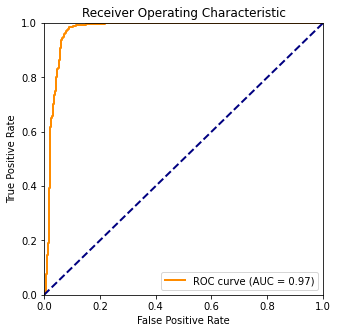

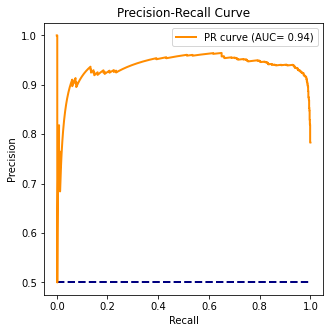

In [107]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def roc_pr_curves(neg, pos):
    # translate to scores from 0 to 1, where 1 means anomaly (low ELBO) and 0 means normal (high ELBO)
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(len(neg))
    y_true_pos = np.ones(len(pos))
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 2
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(recall, precision)

    # plot Precision-Recall curve
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.show()

roc_pr_curves(elbos_normal, elbos_anomaly)